<a href="https://colab.research.google.com/github/Evgeniya371/PRA3024/blob/main/Task_1_(Resonance_modes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='blue'> Task 1 (Resonance modes)


###Run each cell below one by one, read the annotations



*   Run this cell

*   The first three lines can be commented once you run the cell (spicy, pandas and streamlit packages will be already imported into the environment)






In [ ]:
# This cell imports all important packages

#!pip install scipy
#!pip install pandas
#!pip install streamlit_jupyter
import math
from scipy.special import jv, iv, jvp, ivp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import streamlit as st
import matplotlib
from mpl_toolkits import mplot3d
from matplotlib import cm
import scipy.integrate as integrate
from scipy.integrate import dblquad

Run without changes

In [9]:
# This function finds a root within a small interval [x_l, x_u]. The implemented root-finding method is Bisection method

# References:
# https://math.libretexts.org/Under_Construction/Numerical_Methods_with_Applications_(Kaw)/3%3A_Nonlinear_Equations/3.03%3A_Bisection_Methods_for_Solving_a_Nonlinear_Equation
# https://pythonnumericalmethods.berkeley.edu/notebooks/chapter19.03-Bisection-Method.html

def bisection_algorithm(f, x_l, x_u, tolerance, it_num, iter = None):

  # f - function
  # x_l, x_u are initial guesses (lower bound and upper bound respectively)
  # tolerance - percent relative error tolerance specified by user
  # it_num - maximum numer of iterations allowed (it is introduced to prevent infinite loops)
  # iter - iteration counter

    if iter is None:
        iter = 0


  # Check if the upper and lower bounds are roots themselves:
    if f(x_l) == 0:
        return x_l, iter
    if f(x_u) == 0:
        return x_u, iter


  # Check if root is bracketed:
    if f(x_l)*f(x_u)>0:
        #raise Exception("The function does not change sign. No root between x_l and x_u!")
        return None, iter


  # Find a mid-point (estimate of the root):
    x_m = (x_l + x_u)/2


  # Check the following:

    if f(x_l)*f(x_m)==0:
    # The root x_m is found. Terminate the algorithm and report the root.
       return x_m, iter


    if f(x_l)*f(x_m)<0:
    # The root lies between x_l and x_u, it follows that x_l = x_l and x_u = x_m
      x_l = x_l
      x_u = x_m


    if f(x_l)*f(x_m)>0:
    # The root lies between x_m and x_u, it follows that x_l = x_m and x_u = x_u
      x_l = x_m
      x_u = x_u


   # Update the mid-point:
    x_m_old=x_m
    x_m = (x_l + x_u)/2


   # Find the absolute realtive approximate error eps_abs
   # Formula for eps_abs  is |e_a|=|x_m_new-x_m_old)/x_m_new|*100%
    eps_abs=abs((x_m-x_m_old)/x_m)*100

    if eps_abs>tolerance:
     # Aplly the recursive method
      iter += 1
      return bisection_algorithm(f, x_l, x_u, tolerance, it_num, iter=iter)
    else:
     # Accept the estimate of the root otherwise
      return x_m, iter

      # You can print the string shown below to see the number of iterations needed to find each root
      #'Estimated root is %s. \n Number of iterations is %s.'%(x_m, iter)


Run without changes


In [10]:
# This function searches for roots along the specified interval [a, b]. The implemented root-finding method is Bisection method

def roots_bisection_method(f, a, b, tolerance, it_num, step):

  # f - function
  # a and b are the endpoints of the interval. Roots are searched within this interval.
  # tolerance - percent relative error tolerance specified by user
  # it_num - maximum numer of iterations allowed (it is introduced to prevent infinite loops)
  # step - stepsize which is used to search for the roots. It breaks interval [a, b] into small intevals

    roots=[] # This list stores all found roots

    x_l=a
    x_u=a+step
    while x_l<b: # Go along the x axis and break it into small intervals of size 'step' until you reach endpoint b
          root, iter=bisection_algorithm(f, x_l, x_u, tolerance, it_num)
          roots.append(root)
          x_l=x_u
          x_u=x_l+step
    roots=list(filter(lambda item: item is not None, roots)) # This line fileters 'None' values contained in the list roots

    return roots

Run without changes


In [11]:
# This function computes amplitude parameter  C_mn
def C_mn(lambda_mn, poisson_ratio, n):
    numerator=(lambda_mn**2)*jv(n, lambda_mn)+(1-poisson_ratio)*(lambda_mn*jvp(n, lambda_mn)-(n**2)*jv(n, lambda_mn))
    denominator=(lambda_mn**2)*iv(n, lambda_mn)-(1-poisson_ratio)*(lambda_mn*ivp(n, lambda_mn)-(n**2)*iv(n, lambda_mn))
    C_mn=numerator/denominator
    return C_mn

# This function computes frequency f_mn
def frequency_mn(lambda_mn, poisson_ratio, E, h, rho, a):
    D=E*(h**3)/(12*(1-poisson_ratio**2)) # D is flexural rigidity
    frequency_mn=(lambda_mn**2/(2*math.pi*a**2))*math.sqrt(D/(rho*h))
    return frequency_mn

# This function computes angular frequency omega_mn
def angular_frequency_mn(lambda_mn, poisson_ratio, E, h, rho, a):
    angular_frequency_mn=2*math.pi*frequency_mn(lambda_mn, poisson_ratio, E, h, rho, a)
    return angular_frequency_mn

# This function creates a list of eqully speced integers m
# The user should specify up to which number the values m should be computed
def m_list(m):
    return [item for item in range(0, m+1)]

# This function creates a list of eqully speced integers n
# The user should specify up to which number the values n should be computed
def n_list(n):
    return [item for item in range(0, n+1)]


*   Run the cell below

*   You may adjust the decimal places which are to be displayed in the tables. For this, set the desired number of decimal places in the following line:  
s = df.style.format('{:.2f}.')





In [12]:
# This function creates a table of modes
def table_lambda_m_n_values(n_num, m_num, poisson_ratio, a, b, tolerance, it_num, step):

  # n - number of n modes to be computed (corresponds to a number of columns). Each n is number of nodal diameters
  # m - number of m modes to be computed (corresponds to a number of rows). Each m is number of nodal circles
  # poisson_ratio - poisson ratio
  # the parameters listed below are related to the bisection method
  # a and b are the endpoints of the interval. Roots are searched within this interval.
  # tolerance - percent relative error tolerance specified by user
  # it_num - maximum numer of iterations allowed (it is introduced to prevent infinite loops)
  # step - stepsize which is used to search for the roots. It breaks interval [a, b] into small intevals

    # These two lines create the lists of m and n values
    m_values=m_list(m_num)
    n_values=n_list(n_num)

    # Create a dataframe for the table
    df = pd.DataFrame(index=pd.Index(m_values, name='m'), columns=n_values)

    # Create an array to store the value
    lambda_array = np.empty((m_num+1, n_num+1), dtype=float)

    # For loops find list of m valus for each n
    for n in n_values:
         # Function f is (4)-(5) (Amabili et al, p. 686)
         func = lambda x, n, poisson_ratio: ((x ** 2) * jv(n, x) + (1 - poisson_ratio) * (x* jvp(n, x) - (n ** 2) * jv(n, x)))/((x ** 2) * iv(n, x) - (1 - poisson_ratio) * (x * ivp(n, x) - (n ** 2) * iv(n, x)))-((x ** 3) * jvp(n, x) + (n ** 2) * (1 - poisson_ratio) * (x* jvp(n, x) - jv(n, x)))/((x ** 3) * ivp(n, x) - (n ** 2) * (1 - poisson_ratio) * (x * ivp(n, x) - iv(n, x)))
         f = lambda x: func(x, n, poisson_ratio)
         roots = roots_bisection_method(f, a, b, tolerance, it_num, step)
         if n>1:
             roots=roots[1:]
         if n==0 or n==1:
             roots=[np.nan]+roots
         for m in m_values:
             lambda_array[m,n] = roots[m]              # Compute lambda
             df.at[m, n] = roots[m]     # Compute lambda

    file_name = "output.xlsx"
    df.to_excel(file_name,  sheet_name=f"λ values") # The reslut can be exported as Exel table


    # Specify the decimal places to be displayed

    s = df.style.format('{:.2f}')  # Currently, two decimal places are set


    # Formating of the tables:

    cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
    }

    s.set_caption("λ values for n of:")\
    .set_table_styles([{
    'selector': 'caption',
    'props': 'caption-side: top; font-size:1.7em;'
    }], overwrite=False)

    s.set_table_styles([cell_hover])


    return s, lambda_array # First returened element is the table, second element is the array of lambda_mn values

Run without changes

In [18]:
# This function creates a table of modes
def table(m_num, n_num, lambda_array, poisson_ratio, E, h, rho, a):

  # n - number of n modes to be computed (corresponds to a number of columns). Each n is number of nodal diameters
  # m - number of m modes to be computed (corresponds to a number of rows). Each m is number of nodal circles
  # poisson_ratio - poisson ratio
  # the parameters listed below are related to the bisection method
  # a and b are the endpoints of the interval. Roots are searched within this interval.
  # tolerance - percent relative error tolerance specified by user
  # it_num - maximum numer of iterations allowed (it is introduced to prevent infinite loops)
  # step - stepsize which is used to search for the roots. It breaks interval [a, b] into small intevals

    m_values=m_list(m_num)
    n_values=n_list(n_num)
    # These two lines create the lists of m and n values

    for m in m_values:

        # Create a dataframe for the table
        df1 = pd.DataFrame(index=n_values, columns=['m','n', 'C', 'λ', 'f'])
        for n in n_values:
           # Comute the parameters values for the selected (m,n) mode
           lambda_mn = lambda_array[m,n]
           C = C_mn(lambda_mn, poisson_ratio, n)
           frequency = frequency_mn(lambda_mn, poisson_ratio, E, h, rho, a)
           df1.at[n, 'm'] = m
           df1.at[n, 'n'] = n
           df1.at[n, 'C'] = C
           df1.at[n, 'λ'] = lambda_mn
           df1.at[n, 'f'] = frequency


        # Formating of the tables:

        s1=df1.style.hide(axis='index')

        cell_hover = {
        'selector': 'td:hover',
        'props': [('background-color', '#ffffb3')]
        }

        s1.set_caption(f"m = {m}")\
        .set_table_styles([{
        'selector': 'caption',
        'props': 'caption-side: top; font-size:1.7em;'
        }], overwrite=False)

        s1.set_table_styles([cell_hover])


        # The computed tables are streamed into the "output.xlsx" file
        file_name = "output.xlsx"
        with pd.ExcelWriter(file_name, mode='a') as writer:
            df1.to_excel(writer, sheet_name=f"m = {m}")

        # The tables are displayed in the output
        display(s1)




*   You can adjust the value of the ampltidue parameter A in the following line:  
A=0.1*C

*   The display angle can be modified in the following line:
ax.view_init(elev=90, azim=0)  # The display angle

*   Run the cell






In [14]:
# References:
# How to plot 3D surfaces tutorial: https://matplotlib.org/stable/gallery/mplot3d/surface3d_radial.html#sphx-glr-gallery-mplot3d-surface3d-radial-py

# The following function plots the mode shapes
def mode_shape_mn(m, n, lambda_array, poisson_ratio, a):

    # Comute the parameters values for the selected (m,n) mode
    lambda_mn = lambda_array[m,n]
    C = C_mn(lambda_mn, poisson_ratio, n)
    A=0.00000001*C


    # Plot the mode shape

    # Mesh in the polar coordinates
    r = np.linspace(0, a, 100)
    theta = np.linspace(0, 2*np.pi, 100)
    r, theta = np.meshgrid(r, theta)
    # Mesh in the cartesian coordinates
    X, Y = r*np.cos(theta), r*np.sin(theta)
    # Formula for the transverse displacement of the circular plate of radius a (Amabili et al, p. 686)
    W = A*( jv(n, lambda_mn*r/a)+C*iv(n, lambda_mn*r/a) )*np.cos(n*theta)

    # Initialization of the figure
    fig = plt.figure(figsize=plt.figaspect(0.5))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)

    # First subplot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surface = ax.plot_surface(X, Y, W, cmap=cm.seismic)
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'$W(r, \theta)$')
    ax.view_init(elev=30, azim=160)  # The display angle
    fig.colorbar(surface, shrink=0.5, aspect=10, location='left') # Display the colorbar

    # Second subplot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surface = ax.plot_surface(X, Y, W, cmap=cm.seismic)
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.view_init(elev=90, azim=0)  # The display angle
    ax.set_zticks([])

    # Display the sublplots
    fig.suptitle("Mode shape (%s, %s) for a circular plate with radius of %s m"%(m, n, a), fontfamily='serif', fontstyle='italic',y=0.9, fontsize='large')
    plt.show()



*   Specify the parameter values in the cell below
*   Run





In [15]:
# Columns and rows
n_num = 6    # the values of the table are computed up to this number of n
m_num = 6    # the values of the table are computed up to this number of m

# Material parameters
radius = 50/2/1000       # radius of the circular plate (m)
thickness = 1/1000       # thichkness of the circular plate (m)
poisson_ratio  = 0.16    # poisson ratio
E = 71.2*10**9           # Young's modulus (Pa)
density = 2220           # plate's mass density (kg/m^3)

The next two cells compute the mode shape parameters, $C_{mn}$, frequency parameters, $\lambda_{mn}$, and frequencies, $f_{mn}$, for each corresponding mode $(m,n)$. The output is presented in tables.


* Run

* The output is displayed below, but you can also download the table from the folder (open the folder, and download the 'output.xslx' file)

* Optioally, you might adjust these parameters: a, b, tolerance, it_num, step (see comments to the bisection_algorithm() and roots_bisection_method() functions)





In [16]:
# Table of lambda_mn values
tab, lambda_array = table_lambda_m_n_values(n_num = n_num, m_num = m_num, poisson_ratio = poisson_ratio, a = 0.1, b = 50, tolerance = 0.00001, it_num = 100, step = 1)
tab


,0,1,2,3,4,5,6
m,,,,,,,
0,nan,nan,2.40,3.64,4.80,5.93,7.04
1,2.95,4.50,5.95,7.31,8.62,9.89,11.14
2,6.18,7.72,9.18,10.59,11.95,13.29,14.59
3,9.35,10.90,12.38,13.81,15.21,16.58,17.92
4,12.51,14.06,15.55,17.01,18.43,19.82,21.19
5,15.66,17.21,18.72,20.19,21.63,23.04,24.43
6,18.81,20.36,21.88,23.36,24.81,26.24,27.65




*   Run

*   The output is displayed below, but you can also download the table from the folder: open the folder, and download the 'output.xslx' file. The first spreadsheet of the 'output.xslx' stores the $λ_{mn}$ values for each corresponding mode $(m,n)$. Other spreadsheets contain the parameters computed by the following cell



In [19]:
# Table of of resonace frequency values
table(m_num = m_num, n_num = n_num, lambda_array = lambda_array, poisson_ratio = poisson_ratio, E = E, h = thickness, rho = density, a = radius)

m,n,C,λ,f
0,0,nan,nan,nan
0,1,nan,nan,nan
0,2,0.178409,2.400893,2431.028211
0,3,0.070714,3.638271,5582.572655
0,4,0.031414,4.802724,9727.911675
0,5,0.014781,5.932480,14842.837130
0,6,0.007209,7.041124,20908.766024


m,n,C,λ,f
1,0,-0.095484,2.945110,3658.031630
1,1,-0.020256,4.504207,8556.204103
1,2,-0.005640,5.945046,14905.781083
1,3,-0.001810,7.308438,22526.490918
1,4,-0.000636,8.619766,31335.407657
1,5,-0.000238,9.893710,41282.186778
1,6,-0.000093,11.139416,52332.229040


m,n,C,λ,f
2,0,0.003306,6.175467,16083.624389
2,1,0.000734,7.719129,25129.331040
2,2,0.000194,9.182556,35560.802884
2,3,0.000057,10.589610,47293.806707
2,4,0.000018,11.954493,60270.764126
2,5,0.000006,13.286435,74449.413538
2,6,0.000002,14.591815,89797.236184


m,n,C,λ,f
3,0,-0.000133,9.351625,36882.342050
3,1,-0.000029,10.895634,50066.749584
3,2,-0.000007,12.377295,64609.421902
3,3,-0.000002,13.812075,80456.703352
3,4,-0.000001,15.210011,97567.106440
3,5,-0.000000,16.578047,115907.387136
3,6,-0.000000,17.921221,135450.175232


m,n,C,λ,f
4,0,0.000006,12.511017,66013.022905
4,1,0.000001,14.057767,83344.513535
4,2,0.000000,15.552876,102015.411857
4,3,0.000000,17.007348,121988.121400
4,4,0.000000,18.428795,143231.408167
4,5,0.000000,19.822734,165718.689205
4,6,0.000000,21.193317,189427.153334


m,n,C,λ,f
5,0,-0.000000,15.663443,103471.045043
5,1,-0.000000,17.212893,124954.559155
5,2,-0.000000,18.718091,147763.597033
5,3,-0.000000,20.187301,171870.322261
5,4,-0.000000,21.626525,197250.388114
5,5,-0.000000,23.040264,223882.040123
5,6,-0.000000,24.432018,251746.266764


m,n,C,λ,f
6,0,0.000000,18.812321,149255.085467
6,1,0.000000,20.364078,174893.582095
6,2,0.000000,21.877056,201846.912119
6,3,0.000000,23.357711,230093.812377
6,4,0.000000,24.810890,259614.558768
6,5,0.000000,26.240352,290391.355937
6,6,0.000000,27.649070,322407.718630


In order to plot a mode shape $(m,n)$:

*   Specify the $m$ and $n$ numbers in the cell below

*   Run





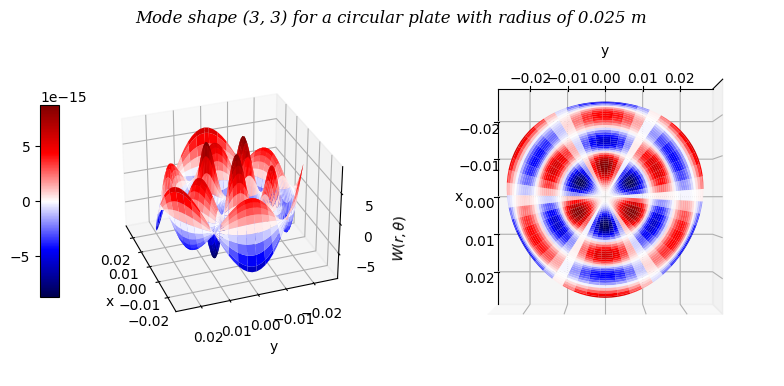

In [18]:
# This cell plots the mode shapes

# The values below are used to plot the mode shapes
m = 3  # nodal circles
n = 3  # nodal diameters

# Plot of the mode shape
mode_shape_mn(m = m, n = n, lambda_array = lambda_array, poisson_ratio = poisson_ratio, a = radius)